In [1]:

from pythetatools.config import *
from pythetatools.config_visualisation import *
from pythetatools.config_osc_params import osc_param_to_title
from pythetatools.base_visualisation import show_minor_ticks


import pythetatools.toyxp as toyxp
from pythetatools.base_analysis import poisson_error_bars

import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.patches import Patch
from osc_prob.default_parameters import *
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use(t2k_style)

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.28/04


In [2]:
dir_ver = 'OA2023'
contours_dir = f"/sps/t2k/dcarabad/Develop/OA2021/P-theta/inputs2023/outputs/ToyXP/Biprobability/Postsyst/"
path_to_asimovbf = f"{inputs_dir}/{dir_ver}/ToyXP/ToyXP_etheta_Bestfit_ptheta_datafit_octant_1_hierarchy_0_bfosc_postsyst.root" 
path_to_data = f"{inputs_dir}/{dir_ver}/ToyXP/Datafile_run11.root"
path_to_asimovbfsystvar = f"{inputs_dir}/{dir_ver}/\
ToyXP/ToyXP_biprob_syst_varied_erec_AsimovBestFitOA2023_Ptheta_Matrix_postPtheta_parameters_values/merged.root"


In [3]:
def get_filename(var_param, ivaried, ifixed, idiscr, mode):
    param_name_to = {'delta':'dCP', 'sin223':'th23', 'dm2':'dm2'}
    if mode == 0:
        idelta = ivaried
        ith23 = ifixed
        idm2 = idiscr
    elif mode == 1:
        idelta = ivaried
        ith23 = ifixed
        idm2 =idiscr
    elif mode == 2:
        idelta = ifixed
        ith23 = ivaried
        idm2 = idiscr
    elif mode == 3:
        idelta = idiscr #in fact MO is different here
        ith23 = ifixed
        idm2 = ivaried
    return f"{inputs_dir}/{dir_ver}/ToyXP/Biprobability/ToyXP_biprob_{param_name_to[var_param]}_erec_delta_{idelta}_th23_{ith23}_MO_{idm2}_postsyst.root"



In [4]:

samples_dict = toyxp.get_samples_info(get_filename("delta", 0, 0, 0, 0))
data = toyxp.load(path_to_data, kind="data",  samples_dict=samples_dict)
asimovbf = toyxp.load(path_to_asimovbf, kind="asimov")


In [5]:
def closest(arr, value, smaller):
    if smaller:
        arr_filtered = arr[arr <= value]  
        if arr_filtered.size == 0:
            return None  
        return arr_filtered[np.argmax(arr_filtered)]
    else:
        arr_filtered = arr[arr >= value]  
        if arr_filtered.size == 0:
            return None  
        return arr_filtered[np.argmin(arr_filtered)]

In [6]:
def get_contour_data(var_param, ifixed_param_array, ivary_param_array, E_x_min, E_x_max, E_y_min, E_y_max, mode):
    
    x_NO = [[] for _ in range(len(ifixed_param_array))]
    y_NO = [[] for _ in range(len(ifixed_param_array))]
    x_IO = [[] for _ in range(len(ifixed_param_array))]
    y_IO = [[] for _ in range(len(ifixed_param_array))]
    
    for i, ifixed in enumerate(ifixed_param_array):
        for ivaried in ivary_param_array:
            asimov = toyxp.load(get_filename(var_param, ivaried, ifixed, 0, mode), kind="asimov")
            x_NO[i].append(np.sum(np.fromiter((asimov[sample_title].slice(E_x_min, E_x_max).contsum() for sample_title in xaxis_sample_titles), dtype=float)))
            y_NO[i].append(np.sum(np.fromiter((asimov[sample_title].slice(E_y_min, E_y_max).contsum() for sample_title in yaxis_sample_titles), dtype=float)))
    
    for i, ifixed in enumerate(ifixed_param_array):
        for ivaried in ivary_param_array:
            asimov = toyxp.load(get_filename(var_param, ivaried, ifixed, 1, mode), kind="asimov")
            x_IO[i].append(np.sum(np.fromiter((asimov[sample_title].slice(E_x_min, E_x_max).contsum() for sample_title in xaxis_sample_titles), dtype=float)))
            y_IO[i].append(np.sum(np.fromiter((asimov[sample_title].slice(E_y_min, E_y_max).contsum() for sample_title in yaxis_sample_titles), dtype=float)))

    x_NO = np.array(x_NO)
    y_NO = np.array(y_NO)
    x_IO = np.array(x_IO)
    y_IO = np.array(y_IO)
    return x_NO, y_NO, x_IO, y_IO



In [7]:

sin2th23_array_4 = np.linspace(0.45, 0.6, 4)
delta_cp_array_4 = [-np.pi/2, 0, np.pi/2, np.pi]
ifixed_4 =  [0, 1, 2, 3]
ifixed_th23_2 =  [0, 2]
ivary_17 = np.arange(0, 17, 1)
idelta_cp_array_4 = np.arange(0, 4, 1)

asimov_dummy = toyxp.load(get_filename('delta', 0, 0, 0, 0), kind="asimov")


In [8]:

def main_setup(mode):
    
    if mode == 0:
        E_x_min, E_x_max = 0, closest(asimov_dummy['nue1R'].bin_edges[0], 3., True)
        E_y_min, E_y_max = 0, closest(asimov_dummy['nuebar1R'].bin_edges[0], 3., True)
        xaxis_sample_titles = ['nue1R', 'nue1RD']
        yaxis_sample_titles = ['nuebar1R']
        var_param = 'delta'
        fixed_param = 'sin223'
        ifixed_param_array = [0, 1, 2, 3]
        ivary_param_array = ivary_17
        iparam_marker_array = [0, 4, 8, 12]
        fixed_param_array = sin2th23_array_4
        marker_labels = [ r'$\delta_{CP}=\pi$', r'$\delta_{CP}=-\pi/2$',  r'$\delta_{CP}=0$', r'$\delta_{CP}=+\pi/2$' ]
    
    elif mode == 1:
        E_x_min, E_x_max = closest(asimov_dummy['nue1R'].bin_edges[0], 0.55, False), closest(asimov_dummy['nue1R'].bin_edges[0], 3., True)
        E_y_min, E_y_max = 0, closest(asimov_dummy['nue1R'].bin_edges[0], 0.55, True)
        xaxis_sample_titles = ['nue1R', 'nuebar1R', 'nue1RD']
        yaxis_sample_titles = ['nue1R', 'nuebar1R', 'nue1RD']
        var_param = 'delta'
        fixed_param = 'sin223'
        ifixed_param_array = [0, 2]
        ivary_param_array = ivary_17
        iparam_marker_array = [0, 4, 8, 12]
        fixed_param_array = sin2th23_array_4
        marker_labels = [ r'$\delta_{CP}=\pi$', r'$\delta_{CP}=-\pi/2$',  r'$\delta_{CP}=0$', r'$\delta_{CP}=+\pi/2$' ]
    
    elif mode == 2:
        E_x_min, E_x_max = 0, closest(asimov_dummy['numu1R'].bin_edges[0], 1.2, True)
        E_y_min, E_y_max = 0, closest(asimov_dummy['nue1R'].bin_edges[0], 3., True)
        xaxis_sample_titles = ['numu1R', 'numubar1R']
        yaxis_sample_titles = ['nue1R', 'nuebar1R', 'nue1RD']
        var_param = 'sin223'
        fixed_param = 'delta'
        ifixed_param_array = [0, 1, 2, 3]
        ivary_param_array = ivary_17
        iparam_marker_array = [6, 8, 10, 12]
        fixed_param_array =  [ r'$-\pi/2$',  r'$0$', r'$\pi/2$', r'$\pi$' ]
        marker_labels = [r'$\sin^2\theta_{23}=0.45$', r'$\sin^2\theta_{23}=0.50$', r'$\sin^2\theta_{23}=0.55$',r'$\sin^2\theta_{23}=0.6$']

    elif mode == 3:
        E_x_min, E_x_max = closest(asimov_dummy['numu1R'].bin_edges[0], 0.6, False), closest(asimov_dummy['numu1R'].bin_edges[0], 1.2, True)
        E_y_min, E_y_max = 0, closest(asimov_dummy['numu1R'].bin_edges[0], 0.6, True)
        xaxis_sample_titles = ['numu1R', 'numubar1R', 'numucc1pi']
        yaxis_sample_titles = ['numu1R', 'numubar1R', 'numucc1pi']
        var_param = 'dm2'
        fixed_param = 'sin223'
        ifixed_param_array = [0, 1, 2, 3]
        ivary_param_array = ivary_17
        iparam_marker_array = [6, 8, 10, 12]
        fixed_param_array = sin2th23_array_4
        marker_labels = [r'$\Delta m^2_{32}=2.45 \times 10^{-3}$' + r'eV$^2$', r'$\Delta m^2_{32}=2.50 \times 10^{-3}$' + r'eV$^2$',
                         r'$\Delta m^2_{32}=2.55 \times 10^{-3}$' + r'eV$^2$', r'$\Delta m^2_{32}=2.60 \times 10^{-3}$' + r'eV$^2$']
    
    return E_x_min, E_x_max, E_y_min, E_y_max, xaxis_sample_titles, yaxis_sample_titles, var_param, fixed_param, ifixed_param_array, ivary_param_array, iparam_marker_array, fixed_param_array, marker_labels 
    

In [9]:
def get_syst_hists(asimovs_systvar):
    nexp_x_systvar = np.zeros(nentries)
    nexp_y_systvar = np.zeros(nentries)
    
    for itoy in tqdm(range(start_entry, start_entry+nentries)):
        nexp_x_systvar[itoy] = sum(asimovs_systvar[f'{sample_title}_{itoy}'].slice(E_x_min, E_x_max).contsum() for sample_title in xaxis_sample_titles)
        nexp_y_systvar[itoy] = sum(asimovs_systvar[f'{sample_title}_{itoy}'].slice(E_y_min, E_y_max).contsum() for sample_title in yaxis_sample_titles)
    return nexp_x_systvar, nexp_y_systvar


In [10]:

import scipy.ndimage

def get_syst_contour(nexp_x_systvar, nexp_y_systvar):
    x = nexp_x_systvar
    y = nexp_y_systvar
    
    # Create a 2D histogram with 50 bins
    bins = 50
    H, xedges, yedges = np.histogram2d(x, y, bins=bins)
    
    # Apply Gaussian smoothing to interpolate the histogram
    H_smooth = scipy.ndimage.gaussian_filter(H, sigma=2.0)
    
    # Flatten the smoothed histogram and sort in descending order
    H_flat = H_smooth.flatten()
    H_sorted = np.sort(H_flat)[::-1]  # Sort values in descending order
    
    # Compute the cumulative sum of normalized values
    H_cumsum = np.cumsum(H_sorted) / H.sum()
    
    # Determine the threshold value corresponding to 68.3% (1σ)
    threshold_value = H_sorted[np.searchsorted(H_cumsum, 0.683)]
    
    # Create meshgrid for plotting
    X, Y = np.meshgrid((xedges[:-1] + xedges[1:]) / 2, 
                        (yedges[:-1] + yedges[1:]) / 2)
    
    return X, Y, H_smooth, threshold_value



In [11]:
def axes_config(ax, mode):
    if mode == 0:
        ax.set_xlim(30, 140)
        ax.set_ylim(10, 30)
        ax.set_xlabel(r'$\nu$ mode e-like candid.', fontsize=20, labelpad=10)
        ax.set_ylabel(r'$\bar{\nu}$ mode e-like candid.', fontsize=20)
        log_leg1 = 'lower left'
    elif mode == 1:
        ax.set_xlim(40, 85)
        ax.set_ylim(25, 90)
        ax.set_xlabel(r'e-like candid. with $E_{rec}>550$ MeV', fontsize=20, labelpad=10)
        ax.set_ylabel(r'e-like candid. with $E_{rec}<550$ MeV', fontsize=20)
        log_leg1 = 'upper left'
    elif mode == 2:
        ax.set_xlim(270, 360)
        ax.set_ylim(65, 190)
        ax.set_xlabel(r'$\mu-$like candid. with $E_{rec}>550$ MeV', fontsize=20, labelpad=10)
        ax.set_ylabel(r'e-like candid. with $E_{rec}<550$ MeV', fontsize=20)
        log_leg1 = 'upper left'
    elif mode == 3:
        ax.set_ylim(70, 220)
        ax.set_xlim(110, 280)
        ax.set_xlabel(r'$\mu-$like candid. with $600 < E_{rec}< 1200$ MeV', fontsize=20, labelpad=10)
        ax.set_ylabel(r'$\mu-$like candid. with $E_{rec}<600$ MeV', fontsize=20)
        log_leg1 = 'lower left'
    return log_leg1

In [12]:
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap

markers = ['v',  '_', 'o', 'P']
fill_styles = ['none', 'full', 'none', 'full']
size_markers = [7, 12, 7, 7]
width_markers = [1.5, 4, 1.5, 2]
color_NO = 'dodgerblue'
color_IO = 'darkorange'

colors_orange = [lightorange, midorange, darkorange, 'brown']
colors_blue = [lightblue, midblue, darkblue, 'darkblue'] 

def Bievent_plot(ax, x_NO, y_NO, x_IO, y_IO, x_NO_marker, y_NO_marker, x_IO_marker, y_IO_marker,
                 X_syst, Y_syst, H_smooth, threshold_value, save=True):
    for i, ifixed_param in enumerate(ifixed_param_array):
        if mode > 1:
            x_dense = np.linspace(y_NO[i][0], y_NO[i][-1], 100)
            f = interp1d(y_NO[i], x_NO[i], kind='quadratic')
            ax.plot(f(x_dense), x_dense, ls='-', color=colors_blue[ifixed_param])
        else:
            ax.plot(x_NO[i], y_NO[i], ls='-', color=colors_blue[ifixed_param])
            
    for i, ifixed_param in enumerate(ifixed_param_array):
        if mode > 1:
            x_dense = np.linspace(y_IO[i][0], y_IO[i][-1], 100)
            f = interp1d(y_IO[i], x_IO[i], kind='quadratic')
            ax.plot(f(x_dense), x_dense, ls='--', color=colors_orange[ifixed_param])
        else:
            ax.plot(x_IO[i], y_IO[i], ls='--', color=colors_orange[ifixed_param])
            
    for i, ifixed_param in enumerate(ifixed_param_array):
        for x, y, marker, fill_style, size, width in zip(x_NO_marker[i], y_NO_marker[i],
                                                         markers, fill_styles, size_markers, width_markers):
            ax.plot(x, y, marker=marker, ls='', fillstyle=fill_style, markerfacecolor=color_NO,
                     markeredgecolor=color_NO, markeredgewidth=width, markersize=size)
    
    for i in range(len(ifixed_param_array)):
        for x, y, marker, fill_style, size, width in zip(x_IO_marker[i], y_IO_marker[i],
                                                         markers, fill_styles, size_markers, width_markers):
            ax.plot(x, y, marker=marker, ls='', fillstyle=fill_style, markerfacecolor=color_IO,
                     markeredgecolor=color_IO, markeredgewidth=width, markersize=size)
    
    
    selected_colors = [colors_orange[i] for i in ifixed_param_array]
    cmap = ListedColormap(selected_colors)
    cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap))
    cb.set_ticklabels([])
    cb.ax.set_position([0.63, 0.11, 0.6, 0.77])  
    
    selected_colors = [colors_blue[i] for i in ifixed_param_array]
    cmap = ListedColormap(selected_colors)
    cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap))
    n = len(ifixed_param_array)
    cb.set_ticks([1/2/n + i/n for i in range(n)])
    cb.set_ticklabels([f'{fixed_param_array[ifixed_param]}' for ifixed_param in ifixed_param_array]) 
    cb.ax.set_position([0.655, 0.11, 0.6, 0.77]) 

    contour_filled = plt.contourf(X_syst, Y_syst, H_smooth.T, levels=[threshold_value, H_smooth.max()], colors=['grey'], alpha=0.25)
    contour_line = plt.contour(X_syst, Y_syst, H_smooth.T, levels=[threshold_value], colors='grey', linewidths=1.)

    for marker, label, fillstyle, size, width in zip(markers, marker_labels, fill_styles, size_markers, width_markers):
        plt.plot([], [], marker=marker, label=label, ls='', color='black', markeredgewidth=width, markersize=size, fillstyle=fillstyle)
    
    
    loc_legend1 = axes_config(ax, mode)
    legend = plt.legend(loc=loc_legend1, fontsize=13)
    ax.add_artist(legend)
    
    x = sum(data[sample_title].slice(E_x_min, E_x_max).contsum() for sample_title in xaxis_sample_titles)
    y = sum(data[sample_title].slice(E_y_min, E_y_max).contsum() for sample_title in yaxis_sample_titles)
    y_err = poisson_error_bars([y],  1 - 0.6827)
    x_err = poisson_error_bars([x],  1 - 0.6827)
    data_handle = plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o', capsize=3, label='Data', color='black', linewidth=2)
    
    x = sum(asimovbf[sample_title].slice(E_x_min, E_x_max).contsum() for sample_title in xaxis_sample_titles)
    y = sum(asimovbf[sample_title].slice(E_y_min, E_y_max).contsum() for sample_title in yaxis_sample_titles)
    bestfit_handle = plt.plot(x, y, marker='d', ls='', label='Best-fit', color='black')[0]
            
    handles = [bestfit_handle, data_handle, Patch(facecolor='grey', edgecolor='grey', alpha=0.5, label='68.27% syst. err. at best-fit')]
    
    plt.legend(handles=handles, loc='upper right', fontsize=15, framealpha=0)
    
    
    ax.text(0.80, 0.9, "NO", fontsize=25, color=darkblue, transform=ax.transAxes)
    ax.text(0.9, 0.9, "IO", fontsize=25, color=darkorange, transform=ax.transAxes)
    ax.text(0.99, 1.05, osc_param_to_title[fixed_param][0], fontsize=20, color='black', transform=ax.transAxes)
    
    show_minor_ticks(ax)

    if save:
        fig.savefig(f'{outputs_dir}/plots/{dir_ver}/Bievent_plots/Bievent_plot_mode{mode}.png', format='png',  dpi=500, bbox_inches='tight')
        fig.savefig(f'{outputs_dir}/plots/{dir_ver}/Bievent_plots/Bievent_plot_mode{mode}.pdf', format='pdf',  bbox_inches='tight')
        fig.savefig(f'{outputs_dir}/plots/{dir_ver}/Bievent_plots/Bievent_plot_mode{mode}.svg', format='svg',  bbox_inches='tight')
        fig.savefig(f'{outputs_dir}/plots/{dir_ver}/Bievent_plots/Bievent_plot_mode{mode}.eps', format='eps',  bbox_inches='tight')
        


## Specify list of modes for each Bievent plot you want ot generate

- mode=0 FHC e-like events vs RHC e-like events
- mode=1 e-like low-energy events  vs e-like high-energy events 
- mode=2 mu-like events vs e-like events
- mode=3 mu-like low-energy events vs RHC mu-like high-energy events

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 915.31it/s]
/var/folders/0f/cdw_py7n73s4cjyjq7pvfpl40000gn/T/ipykernel_69223/1819957683.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap))
/var/folders/0f/cdw_py7n73s4cjyjq7pvfpl40000gn/T/ipykernel_69223/1819957683.py:53: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap))


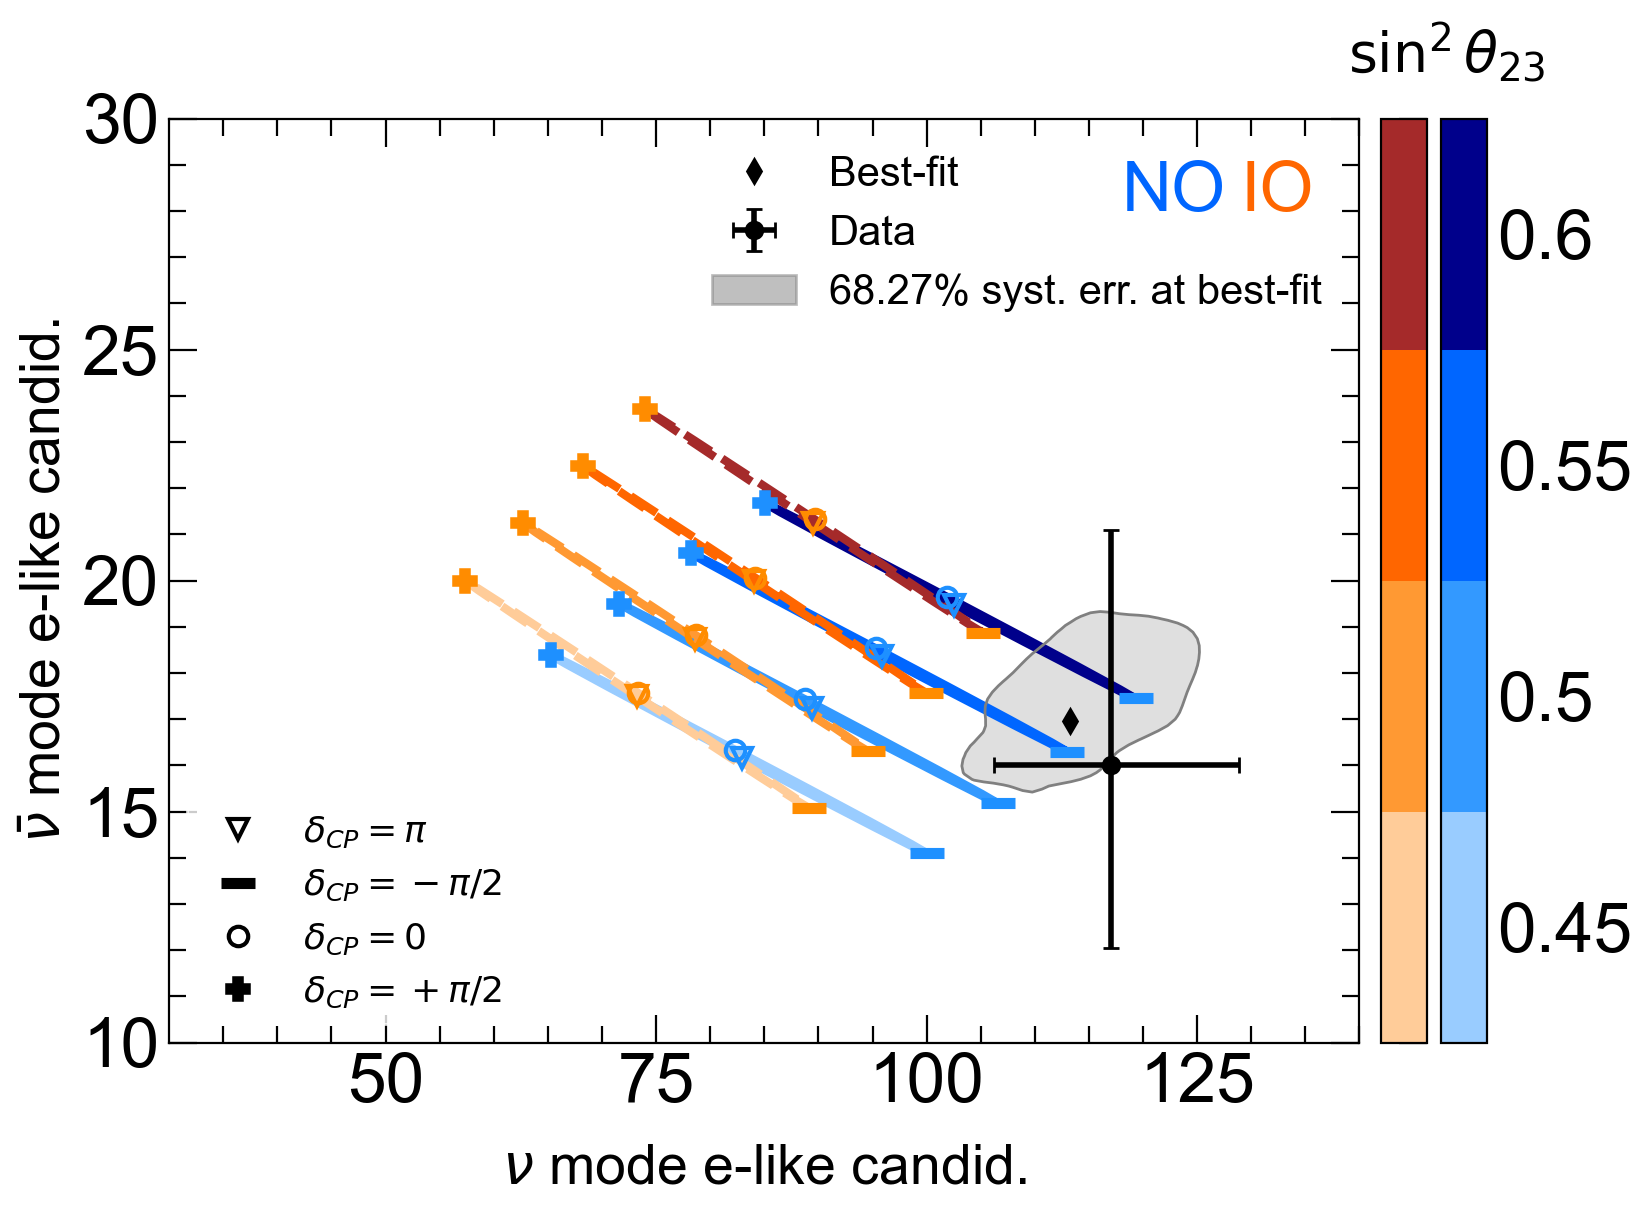

In [13]:
modes_list = [0]

for mode in modes_list:
    start_entry = 0
    nentries = 1000
    
    E_x_min, E_x_max, E_y_min, E_y_max, xaxis_sample_titles,\
    yaxis_sample_titles, var_param, \
    fixed_param, ifixed_param_array, ivary_param_array, iparam_marker_array, fixed_param_array, marker_labels = main_setup(mode)
    
    x_NO, y_NO, x_IO, y_IO = \
    get_contour_data(var_param, ifixed_param_array, ivary_param_array, E_x_min, E_x_max, E_y_min, E_y_max, mode)
    x_NO_marker, y_NO_marker, x_IO_marker, y_IO_marker = \
    get_contour_data(var_param, ifixed_param_array, iparam_marker_array, E_x_min, E_x_max, E_y_min, E_y_max, mode)
    
    asimovs_systvar = toyxp.load_multiple_hists_from_tree(path_to_asimovbfsystvar, set(xaxis_sample_titles+yaxis_sample_titles), start_entry, nentries)
    
    nexp_x_systvar, nexp_y_systvar = get_syst_hists(asimovs_systvar)
    X_syst, Y_syst, H_smooth, threshold_value = get_syst_contour(nexp_x_systvar, nexp_y_systvar)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    Bievent_plot(ax, x_NO, y_NO, x_IO, y_IO, x_NO_marker, y_NO_marker, x_IO_marker, y_IO_marker, X_syst,
                 Y_syst, H_smooth, threshold_value, save=False)